--- 1. BLS SEARCH ---
BLS Found: P=0.8046, T0=-0.0100
Bad Guess P  : 0.80556 (True: 0.8)
Bad Guess T0 : -0.01500 (True: 0.0)
Bad Guess a  : 10.0   (True: 5.0)

--- 3. RUNNING 2-STAGE OPTIMIZATION ---
  > Stage 1: Fixing Geometry...
    Stage 1 P: 0.80001
  > Stage 2: Refining Fit...
Optimization Success: True
Recovered P  : 0.80001
Recovered a  : 4.99098

--- 4. RUNNING MCMC ---


100%|██████████| 3000/3000 [07:35<00:00,  6.58it/s]


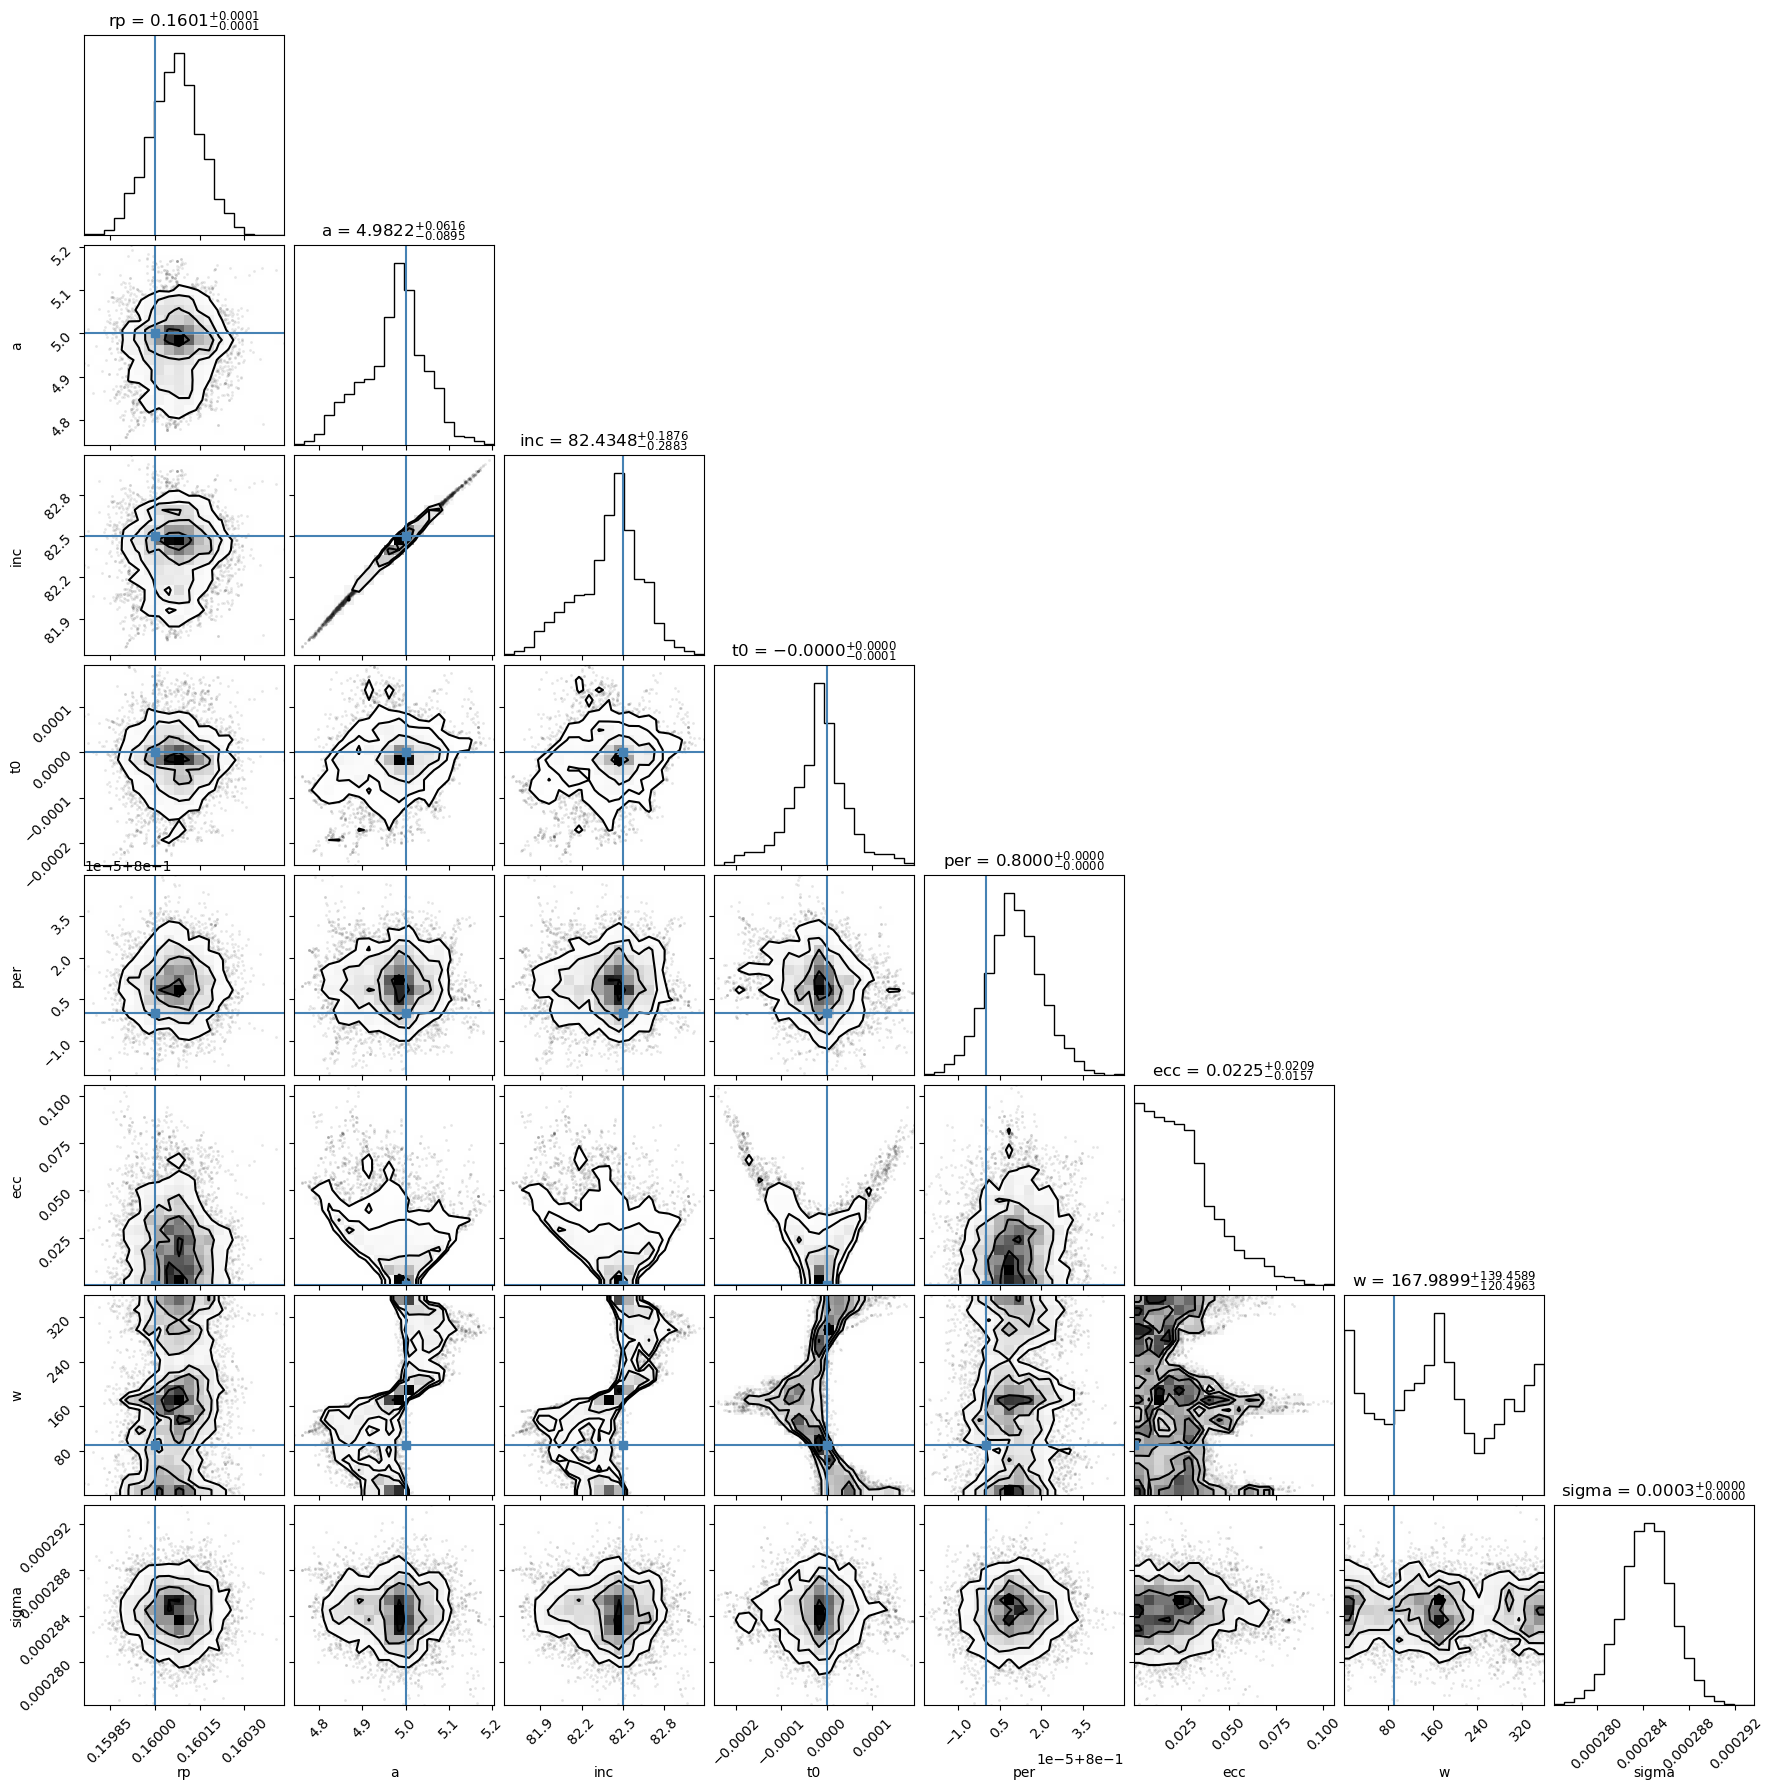

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee
import corner
from scipy.optimize import minimize
from astropy.timeseries import BoxLeastSquares

# ==========================================
# 1. GENERATE SYNTHETIC DATA
# ==========================================
np.random.seed(42)

true_params = {
    "rp": 0.16, "a": 5.0, "inc": 82.5, "t0": 0.0, 
    "per": 0.8, "ecc": 0, "w": 90.0, "u": [0.3, 0.2], "sigma": 3e-4
}

t = np.linspace(-0.2, 2.2, 10000)

def batman_model(theta, time):
    rp, a, inc, t0, per, ecs, ess, _ = theta
    ecc = ecs**2 + ess**2
    w_deg = np.degrees(np.arctan2(ess, ecs))
    if w_deg < 0: w_deg += 360.0

    if ecc >= 1.0 or a <= 0: return np.ones_like(time)

    params = batman.TransitParams()
    params.t0 = t0; params.per = per; params.rp = rp; params.a = a; params.inc = inc
    params.ecc = ecc; params.w = w_deg; params.u = [0.3, 0.2]; params.limb_dark = "quadratic"
   
    m = batman.TransitModel(params, time)
    return m.light_curve(params)

# Create True Flux
true_ecs = np.sqrt(true_params["ecc"]) * np.cos(np.radians(true_params["w"]))
true_ess = np.sqrt(true_params["ecc"]) * np.sin(np.radians(true_params["w"]))
theta_true = [true_params["rp"], true_params["a"], true_params["inc"], true_params["t0"],
              true_params["per"], true_ecs, true_ess, np.log(true_params["sigma"])]

flux_true = batman_model(theta_true, t)
flux = flux_true + np.random.normal(0, true_params["sigma"], size=len(t))
flux_err = np.ones_like(t) * 1e-4

# ==========================================
# 2. BLS SEARCH
# ==========================================
print("--- 1. BLS SEARCH ---")
model_bls = BoxLeastSquares(t, flux)
period_grid = np.linspace(0.5, 2.0, 5000)
periodogram = model_bls.power(period_grid, duration=0.1, objective="snr")

best_ix = np.argmax(periodogram.power)
bls_per = periodogram.period[best_ix]
bls_t0 = periodogram.transit_time[best_ix]
bls_depth = periodogram.depth[best_ix]
bls_rp = np.sqrt(bls_depth)
print(f"BLS Found: P={bls_per:.4f}, T0={bls_t0:.4f}")

# ==========================================
# 3. STRESS TEST (BAD GUESS)
# ==========================================
# We start with the intentionally BAD guesses
guess_a = 10.0
guess_inc = 85.0
guess_per = bls_per + 0.001 
guess_t0 = bls_t0 - 0.005   
guess_ecs = 0.0
guess_ess = 0.0

# Initial guess vector (Geometry only for stage 1)
initial_guess_geo = np.array([
    bls_rp, guess_a, guess_inc, guess_t0, guess_per, guess_ecs, guess_ess
])

print(f"Bad Guess P  : {guess_per:.5f} (True: {true_params['per']})")
print(f"Bad Guess T0 : {guess_t0:.5f} (True: {true_params['t0']})")
print(f"Bad Guess a  : {guess_a:.1f}   (True: {true_params['a']})")

# ==========================================
# 4. TWO-STAGE OPTIMIZATION
# ==========================================
print("\n--- 3. RUNNING 2-STAGE OPTIMIZATION ---")

rho_obs_mean = (true_params["a"]**3) / (true_params["per"]**2)
rho_obs_sigma = 0.1 * rho_obs_mean

def ln_prior(theta):
    rp, a, inc, t0, per, ecs, ess, ln_sigma = theta
    if not (0.01 < rp < 1.0): return -np.inf
    if not (1.0 < a < 100.0): return -np.inf
    if not (60.0 < inc < 90.0): return -np.inf
    if not (t.min() < t0 < t.max()): return -np.inf
    if not (0.2 < per < 3.0): return -np.inf
    if not (-15.0 < ln_sigma < 1.0): return -np.inf # Keep sigma bounded
    
    ecc_sq = ecs**2 + ess**2
    if ecc_sq >= 0.9: return -np.inf
    
    # 0-90 degree constraint (Optional, but helps stability)
    w_deg = np.degrees(np.arctan2(ess, ecs))
    if w_deg < 0: w_deg += 360.0
    # Uncomment if you want to strictly enforce 0-90 again
    # if not (0 < w_deg < 90): return -np.inf

    rho_model = (a**3) / (per**2)
    lp_density = -0.5 * ((rho_model - rho_obs_mean) / rho_obs_sigma)**2
    
    return lp_density

# --- STAGE 1 FUNCTION: Fixed Sigma ---
def neg_ln_posterior_stage1(theta_geo, time, flux, flux_err):
    # Lock sigma to the median error
    fixed_ln_sigma = np.log(np.median(flux_err)) 
    theta_full = np.concatenate([theta_geo, [fixed_ln_sigma]])
    
    lp = ln_prior(theta_full)
    if not np.isfinite(lp): return 1e25
    
    try:
        model = batman_model(theta_full, time)
    except:
        return 1e25
        
    resid = flux - model
    chisq = np.sum((resid / flux_err) ** 2)
    return chisq - lp 

# --- STAGE 2 FUNCTION: Free Sigma ---
def neg_ln_posterior_stage2(theta_full, time, flux, flux_err):
    # Now we fit everything, including sigma
    lp = ln_prior(theta_full)
    if not np.isfinite(lp): return 1e25
    
    rp, a, inc, t0, per, ecs, ess, ln_sigma = theta_full
    sigma_jitter = np.exp(ln_sigma)
    sigma_total_sq = flux_err**2 + sigma_jitter**2
    
    try:
        model = batman_model(theta_full, time)
    except:
        return 1e25

    resid = flux - model
    ln_like = -0.5 * np.sum( (resid**2 / sigma_total_sq) + np.log(2.0 * np.pi * sigma_total_sq) )
    return -(lp + ln_like)

# RUN STAGE 1 (Robust Geometry)
print("  > Stage 1: Fixing Geometry...")
soln1 = minimize(neg_ln_posterior_stage1, initial_guess_geo,
                 args=(t, flux, flux_err), method='Nelder-Mead')
print(f"    Stage 1 P: {soln1.x[4]:.5f}")

# RUN STAGE 2 (Refine Eccentricity & Sigma)
# We take the result from Stage 1, append a guess for sigma, and optimize again.
initial_guess_stage2 = np.concatenate([soln1.x, [np.log(1e-4)]])

print("  > Stage 2: Refining Fit...")
soln2 = minimize(neg_ln_posterior_stage2, initial_guess_stage2,
                 args=(t, flux, flux_err), method='Nelder-Mead')

print(f"Optimization Success: {soln2.success}")
print(f"Recovered P  : {soln2.x[4]:.5f}")
print(f"Recovered a  : {soln2.x[1]:.5f}")

# ==========================================
# 5. MCMC
# ==========================================
print("\n--- 4. RUNNING MCMC ---")

def ln_posterior(theta, time, flux, flux_err):
    # Same as Stage 2 but positive sign
    return -neg_ln_posterior_stage2(theta, time, flux, flux_err)

ndim = 8
nwalkers = 50

# Use the STAGE 2 (Refined) solution to start walkers
pos = soln2.x + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(t, flux, flux_err))
sampler.run_mcmc(pos, 3000, progress=True)

# ==========================================
# 6. RESULTS
# ==========================================
tau = sampler.get_chain().shape[0]
discard = int(tau * 0.3)
flat_samples = sampler.get_chain(discard=discard, thin=15, flat=True)

rp = flat_samples[:, 0]
a = flat_samples[:, 1]
inc = flat_samples[:, 2]
t0 = flat_samples[:, 3]
per = flat_samples[:, 4]
ecc = flat_samples[:, 5]**2 + flat_samples[:, 6]**2
w = np.degrees(np.arctan2(flat_samples[:, 6], flat_samples[:, 5]))
w[w<0] += 360
sigma = np.exp(flat_samples[:, 7])

samples_phys = np.vstack([rp, a, inc, t0, per, ecc, w, sigma]).T
labels = ["rp", "a", "inc", "t0", "per", "ecc", "w", "sigma"]
truths = [true_params["rp"], true_params["a"], true_params["inc"], true_params["t0"],
          true_params["per"], true_params["ecc"], true_params["w"], true_params["sigma"]]

corner.corner(samples_phys, labels=labels, truths=truths, show_titles=True, title_fmt=".4f")
plt.show()